# **Annotation of artefacts**


## Introduction

In this chapter it will be shown here how artefacts can be identified and then annotated. The annotations will be represented in the FIF data file. Sections or trials will not be rejected at this stage; rather the annotations may be used later. For instance, they can be used to reject trials with eyeblinks or muscle contractions depending on their relevance for the analysis.


## Preparation

#### Import the necessary modules

Below are the required Python modules to be imported


In [1]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
import array
import os.path as op
from mne_bids import (
    BIDSPath,
    read_raw_bids
)
from mne.preprocessing import annotate_muscle_zscore

#### File overview

#### The chapter relies on the input files (embedded in the BIDS structure):
```

< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif

```


#### and generates the output files:

```

< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif

< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.csv

```

## Loading the BIDS data
#### Specify your BIDS parameters along with the BIDS folder path


In [2]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '01'
meg_suffix = 'meg'
hfc_suffix = 'raw_hfc'
ann_suffix = 'ann'

data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
deriv_root = op.join(bids_root, "derivatives/preprocessing")

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=hfc_suffix, 
            root=deriv_root, extension='.fif', check=False)

deriv_fname = bids_path.basename.replace(hfc_suffix, ann_suffix) # fif output filename
deriv_fname_fif = op.join(bids_path.directory, deriv_fname)
deriv_fname_csv = deriv_fname_fif.replace('fif', 'csv') # csv output filename

print(bids_path)
print(deriv_fname_fif)
print(deriv_fname_csv)

C:/Users/rakshita/Documents/Cerca_raw_files/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif
C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ann.fif
C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ann.csv


#### Read the raw data

In [3]:
raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)

Opening raw data file C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif...


C:\Users\rakshita\AppData\Local\Temp\ipykernel_20808\1492964947.py:1: RuntimeWarning: This filename (C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)


    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 176) active
        HFC: l=1 m=0 (1 x 176) active
        HFC: l=1 m=1 (1 x 176) active
        HFC: l=2 m=-2 (1 x 176) active
        HFC: l=2 m=-1 (1 x 176) active
        HFC: l=2 m=0 (1 x 176) active
        HFC: l=2 m=1 (1 x 176) active
        HFC: l=2 m=2 (1 x 176) active
    Range : 0 ... 1539807 =      0.000 ...  2053.076 secs
Ready.
Reading 0 ... 1539807  =      0.000 ...  2053.076 secs...


C:\Users\rakshita\AppData\Local\Temp\ipykernel_20808\1492964947.py:1: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\**\meg\sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
C:\Users\rakshita\AppData\Local\Temp\ipykernel_20808\1492964947.py:1: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\**\meg\sub-01_ses-01*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
C:\Users\rakshita\AppData\Local\Temp\ipykernel_20808\1492964947.py:1: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "C:\Users\rakshit

## Detecting Eye Blink Artefacts Using OPM Channels

In this procedure, artefacts related to eye blinks are automatically detected based on the signal from OPM channels, without relying on a conventional EOG channel.

Unlike traditional MEG systems, which include dedicated EOG electrodes, here we estimate eye blinks using two frontal OPM channels near the two eyes:

- F9 A4 Z  
- F10 B3 Z

To approximate an EOG signal, the difference between these two frontal channels is computed. The resulting signal is then assigned to `Trigger 2`, effectively acting as a EOG channel.

After applying a bandpass filter in the range of 1–10 Hz to isolate the frequency components associated with eye movements, the detection threshold for blinks is defined as:

$$
\text{Threshold} = \frac{\max(\text{Trigger 2}) - \min(\text{Trigger 2})}{4}
$$

A blink is identified when the signal on `Trigger 2` exceeds this threshold. Once a blink is detected, a corresponding segment of data is marked (annotated) as a blink artefact. Each annotated segment:

- is 500 milliseconds long  
- starts 250 milliseconds before the threshold is crossed


In [4]:
# Extract data from the two frontal OPM channels
ch1_data = raw.copy().pick_channels(['F9 A4 Z']).get_data()[0]
ch2_data = raw.copy().pick_channels(['F10 B3 Z']).get_data()[0]

# The differential signal (Left -Right)
eog_signal = ch1_data - ch2_data

# Assign EOG data to Trigger 2
raw._data[raw.ch_names.index('Trigger 2')] = eog_signal


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [6]:
eog_events = mne.preprocessing.find_eog_events(raw, ch_name='Trigger 2',thresh=0.25e-11) 

Using EOG channel: Trigger 2
EOG channel index for this subject is: [1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Trigger 2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 7500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 838 significant peaks
Number of EOG events detected: 838


In total, 1074 events were indentified as blinks. In order to write these events on the dataset, we need to create an Annotation object which contains the onset of each blink, their durations and a description (i.e., tag) of the type of event:

In [7]:
n_blinks = len(eog_events)
onset = eog_events[:, 0] / raw.info['sfreq'] - 0.25
duration = np.repeat(0.5, n_blinks)
description = ['blink'] * n_blinks
orig_time = raw.info['meas_date']
annotations_blink = mne.Annotations(onset, duration, description, orig_time)


## Finding muscle artefacts

Muscle artefacts are identified from the magnetometer data filtered in the 105 - 130 Hz range. The data are subsequently z-scored. If they exceed the value threshold_muscle, the corresponding section of data is annotated as muscle artifact. The shortest allowed duration of non-annotated data is 0.2 s; shorter segments will be incorporated into the surrounding annotations.


#### Before computing the Z score make sure the 'bad' channels are removed.

In [8]:
raw_clean = raw.copy().drop_channels(raw.info['bads'])

#### Compute the Z score

In [9]:
threshold_muscle = 3 
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    raw_clean, ch_type="mag", threshold=threshold_muscle, min_length_good=0.1,
    filter_freq=[105, 130])


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1e+02 - 1.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 105.00
- Lower transition bandwidth: 26.25 Hz (-6 dB cutoff frequency: 91.88 Hz)
- Upper passband edge: 130.00 Hz
- Upper transition bandwidth: 32.50 Hz (-6 dB cutoff frequency: 146.25 Hz)
- Filter length: 95 samples (0.127 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   15.5s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1239 samples (1.652 s)



#### To check whether the threshold used for the muscle annotation is good for the current data, we plot the z-scores across the recording. The threshold is indicated by a red line.

[Text(0.5, 0, 'time, (s)'),
 Text(0, 0.5, 'zscore'),
 Text(0.5, 1.0, 'Muscle activity (threshold = 3)')]

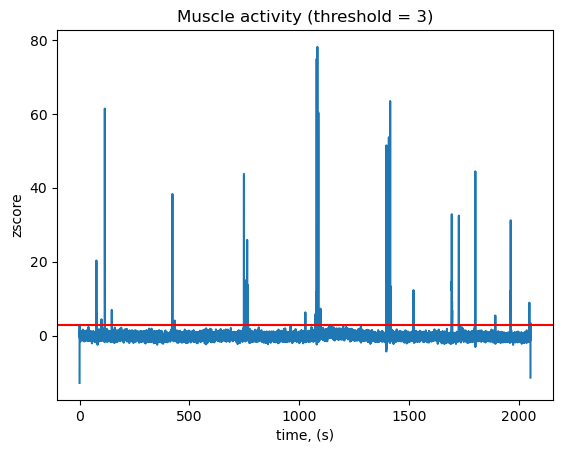

In [10]:
%matplotlib inline
fig1, ax = plt.subplots()
ax.plot(raw_clean.times, scores_muscle);
ax.axhline(y=threshold_muscle, color='r')
ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity (threshold = %s)' % threshold_muscle)

## Include annotations in dataset and Inspect

Now mark all the annotations in the data set.

Since calling set_annotations() replaces any existing annotations in the Raw object, the original annotations are first extracted and then combined with the blink and muscle annotations before being reassigned.

In [11]:
annotations_event = raw.annotations 
raw_clean.set_annotations(annotations_event + annotations_blink + annotations_muscle)

C:\Users\rakshita\AppData\Local\Temp\ipykernel_20808\2036331298.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_clean.set_annotations(annotations_event + annotations_blink + annotations_muscle)


<Raw | sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif, 203 x 1539808 (2053.1 s), ~2.33 GiB, data loaded>

#### To inspet the annotations write

In [12]:
%matplotlib inline
raw_clean.plot(start=50)

Using qt as 2D backend.


<mne_qt_browser._pg_figure.MNEQtBrowser(0x2166194d0d0) at 0x0000021825FC2480>

Channels marked as bad:
none


C:\Users\rakshita\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


To specifically inspect the ocular artefacts display the EOG channel assigned before in this chapter.

In [13]:
raw_clean.set_channel_types({'Trigger 2':'eog'})
eog_picks=mne.pick_types(raw_clean.info,meg=False,eog=True)
raw_clean.plot(order=eog_picks,start=50)

<mne_qt_browser._pg_figure.MNEQtBrowser(0x21849d2eed0) at 0x0000021847103600>

### Save the artefact annotations

Save the annotations in a file to be used in the subsequent sections:

In [ ]:
raw_clean.save(deriv_fname_fif, overwrite=True)
raw_clean.annotations.save(deriv_fname_csv, overwrite=True)

## References

- Muthukumaraswamy, S. (2013). *High-frequency brain activity and muscle artifacts in MEG/EEG: a review and recommendations*. *Frontiers in Human Neuroscience*, **7**, 138. [https://doi.org/10.3389/fnhum.2013.00138](https://doi.org/10.3389/fnhum.2013.00138)

- Hu, Y., Yin, C., Zhang, J., & Wang, Y. (2018). *Partial Least Square Aided Beamforming Algorithm in Magnetoencephalography Source Imaging*. *Frontiers in Neuroscience*, **12**, 616. [https://doi.org/10.3389/fnins.2018.00616](https://doi.org/10.3389/fnins.2018.00616)
